In [2]:

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

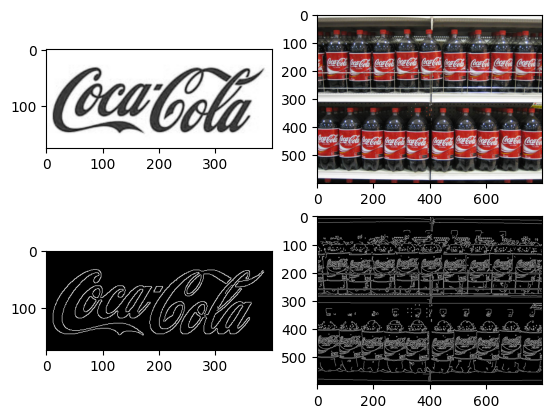

In [21]:
target = cv.imread('./images/coca_multi.png')

target_rgb= cv.cvtColor(target, cv.COLOR_BGR2RGB)
target_gray= cv.cvtColor(target, cv.COLOR_BGR2GRAY)

template = cv.imread('./template/pattern.png',0) 

target_edges = cv.Canny(target_gray, threshold1=100, threshold2=200)


plt.figure()
plt.subplot(2,2,1)
plt.imshow(template, cmap='gray')
plt.subplot(2,2,2)
plt.imshow(target_rgb)
plt.subplot(2,2,3)
plt.imshow(template_edges, cmap='gray')
plt.subplot(2,2,4)
plt.imshow(target_edges, cmap='gray')

In [ ]:

# --- Asumimos que estas variables ya existen ---
# template: la imagen de la plantilla original (antes de Canny)
# target_edges: la imagen principal con los bordes detectados
# target_rgb: la imagen principal original en color (BGR)
# ---------------------------------------------
def doit(target_file, template_file):

    target = cv.imread(target_file)
    target_rgb= cv.cvtColor(target, cv.COLOR_BGR2RGB)
    target_gray= cv.cvtColor(target, cv.COLOR_BGR2GRAY)

    template = cv.imread(template_file,0) 

    target_edges = cv.Canny(target_gray, threshold1=100, threshold2=200)

    def resize_template(template, scale, target_shape):
        """Redimensiona el template y aplica Canny."""
        width = int(template.shape[1] * scale)
        height = int(template.shape[0] * scale)

        if width > target_shape[1] or height > target_shape[0]:
            return None

        resized = cv.resize(template, (width, height), interpolation=cv.INTER_AREA)
        edges = cv.Canny(resized, 100, 200)
        return (edges, width, height)

    def find_best_score(target, template, method):
        """Calcula y normaliza el score de coincidencia."""
        res = cv.matchTemplate(target, template, method)
        min_val, max_val, _, _ = cv.minMaxLoc(res)
        
        if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
            return 1 - min_val
        else:
            return max_val

    scores = []
    methods_to_test = [cv.TM_CCOEFF_NORMED, cv.TM_CCORR_NORMED, cv.TM_SQDIFF_NORMED]

    ###
    # Detección 
    ###
    print("Buscando la mejor combinación de escala y método...")
    for method in methods_to_test:
        for scale in np.linspace(0.2, 2.0, 20):
            # Redimensionar el template y manejar el caso de que sea muy grande
            resize_result = resize_template(template, scale, target_edges.shape)
            if resize_result is None:
                continue
                
            resized_template_edges, _, _ = resize_result
            
            score = find_best_score(target_edges, resized_template_edges, method)
            print(score, scale)

            scores.append(np.array([score, scale, method]))

    # Convertir la lista de arrays en una matriz NumPy para un ordenamiento eficiente
    scores_matrix = np.array(scores)

    # Ordenar la matriz por la primera columna (score) en orden descendente
    # argsort devuelve los índices que ordenarían el array
    sorted_indices = np.argsort(scores_matrix[:, 0])[::-1]
    sorted_scores = scores_matrix[sorted_indices]

    print(sorted_scores[0:10])

    # Obtener los mejores parámetros del primer elemento
    max_score, best_scale, best_method = sorted_scores[0]

    print(f"\nMejor resultado encontrado:")
    print(f"  - Score: {max_score:.4f}")
    print(f"  - Escala: {best_scale:.2f}")
    print(f"  - Método: {int(best_method)}") # Convertimos a int para verlo más claro

    # Generar el mejor template una última vez para la detección final
    best_template_edges, w, h = resize_template(template, best_scale, target_edges.shape)

    if resize_result is None:
        raise ValueError('Oh no! nada puede malir sal')

    # Realizar la detección final con los mejores parámetros
    res = cv.matchTemplate(target_edges, best_template_edges, int(best_method))

    threshold = 0.8 * max_score # Umbral dinámico basado en el mejor score
    loc = np.where(res >= threshold)

    boxes_candidatas = []
    scores_candidatos = []
    for pt in zip(*loc[::-1]):
        # El formato para NMSBoxes es (x, y, w, h)
        boxes_candidatas.append([pt[0], pt[1], w, h])
        scores_candidatos.append(res[pt[1], pt[0]])

    print(f"\nSe encontraron {len(boxes_candidatas)} cajas candidatas en bruto.")


    # El umbral de IoU: si dos cajas se superponen más de un 30%, se considera redundante.
    IOU_THRESHOLD = 0.3
    indices = cv.dnn.NMSBoxes(boxes_candidatas, scores_candidatos, 0, IOU_THRESHOLD)

    # 3. Dibujar solo las cajas finales que sobrevivieron a NMS
    img_salida = target_rgb.copy()
    if len(indices) > 0:
        # indices puede ser una lista de listas, por eso usamos .flatten()
        for i in indices.flatten():
            (x, y, w_box, h_box) = boxes_candidatas[i]
            pt1 = (x, y)
            pt2 = (x + w_box, y + h_box)
            cv.rectangle(img_salida, pt1, pt2, (0, 255, 0), 2)
            # Opcional: poner el score de la caja final
            score_final = scores_candidatos[i]
            texto = f"{score_final:.2f}"
            cv.putText(img_salida, texto, (x, y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

    print(f"Después de NMS con IoU, quedaron {len(indices)} cajas finales.")

    plt.figure(figsize=(10, 8)) # Hacemos la figura un poco más grande
    # OpenCV usa BGR y Matplotlib usa RGB, por eso convertimos el color
    plt.imshow(img_salida)
    plt.title('Detecciones Finales con la Mejor Escala')
    plt.xticks([]), plt.yticks([]) # Ocultar los ejes
    plt.show()

In [111]:
doit('./images/coca_multi.png', './template/pattern.png')


Buscando la mejor combinación de escala y método...
0.1933312565088272
0.1509302854537964
0.12244464457035065
0.0821852833032608
0.08737070113420486
0.07847372442483902
0.06928662955760956
0.05430608615279198
0.04901248589158058
0.0506562776863575
0.05040264129638672
0.049639590084552765
0.049482520669698715
0.04615313559770584
0.04269295185804367
0.04406255856156349
0.03882567211985588
0.037704940885305405
0.038393013179302216
0.3772635757923126
0.316209077835083
0.2669449746608734
0.22544699907302856
0.20042839646339417
0.18864086270332336
0.16904613375663757
0.15396574139595032
0.1456739902496338
0.13932639360427856
0.13424766063690186
0.12743784487247467
0.126039519906044
0.11993145942687988
0.11538773030042648
0.11087591201066971
0.10812436789274216
0.10380818694829941
0.10131406038999557
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
[[0.37726358 0.2        3.        ]
 [0.31620908 0.29473684 3.        ]
 [0.26694497 0.38947368 3.        ]
 [0.225447 

ValueError: Oh no! nada puede malir sal

In [110]:
doit('./images/logo_1.png', './template/pattern.png')


Buscando la mejor combinación de escala y método...
0.1559016853570938
0.14084577560424805
0.09508601576089859
0.09315963834524155
0.0790056511759758
0.10569767653942108
0.12613339722156525
0.08218992501497269
0.075762078166008
0.06072436645627022
0.05523834750056267
0.05194079130887985
0.05520917847752571
0.047445423901081085
0.0406666174530983
0.032813310623168945
0.024538280442357063
0.30664345622062683
0.24140553176403046
0.215407595038414
0.20751672983169556
0.18182207643985748
0.19509533047676086
0.20301319658756256
0.15157687664031982
0.13797219097614288
0.1162249743938446
0.10634752362966537
0.09710530191659927
0.09589368104934692
0.08600042760372162
0.07550923526287079
0.06570365279912949
0.05765261873602867
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
[[0.30664346 0.2        3.        ]
 [0.24140553 0.29473684 3.        ]
 [0.2154076  0.38947368 3.        ]
 [0.20751673 0.48421053 3.        ]
 [0.2030132  0.76842105 3.        ]
 [0.19509533 0.67368421 3

ValueError: Oh no! nada puede malir sal